In [1]:
import pandas as pd
import numpy as np 

from pathlib import Path

In [10]:
from gensim import corpora
from gensim.parsing.preprocessing import strip_non_alphanum, strip_numeric
from gensim.parsing.preprocessing import strip_punctuation, strip_short, remove_stopwords
from gensim.parsing.preprocessing import preprocess_string, STOPWORDS
from gensim.utils import lemmatize

In [3]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
docdir = Path('../data/docs')

In [5]:
raw_corpus = []

In [6]:
files = list(docdir.glob('*.body'))
for f in files:
    with open(f, 'r') as fp:
        raw_corpus.append(fp.read())
        fp.close()

In [7]:
corpus = []
for doc in raw_corpus:
    # from this lemmatization tutorial
    # https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
    lemmatized = [wd.decode('utf-8').split('/')[0] for wd in lemmatize(doc)]
    corpus.append(lemmatized)


In [11]:
# strip short words and stop words from the lemmatized corpus 
def strip_list(wordlist):
    return [w for w in wordlist if len(w)> 3 and w not in STOPWORDS ]

corpus = [ strip_list(words) for words in corpus ]

In [12]:
dictionary = corpora.Dictionary(tokens for tokens in corpus)

2019-02-23 19:07:46,166 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-02-23 19:07:46,244 : INFO : built Dictionary(4417 unique tokens: ['acquisition', 'aircraft', 'authorize', 'available', 'capital']...) from 1248 documents (total 93137 corpus positions)


In [13]:
tokened_corpus = [dictionary.doc2bow(tokens) for tokens in corpus ]

In [15]:
# dimensionality reduction
from gensim.models import TfidfModel, LsiModel

In [14]:
# first convert words to tfidf values
tfidf = TfidfModel(dictionary=dictionary, normalize=True)
vectored_corpus = [ tfidf[doc] for doc in tokened_corpus]

In [16]:
# next do dimensionalty reduction
lsi = LsiModel(corpus=tokened_corpus, num_topics=200, id2word=dictionary, onepass=False, power_iters=3)

2019-02-23 19:08:36,187 : INFO : using serial LSI version on this node
2019-02-23 19:08:36,188 : INFO : updating model with new documents
2019-02-23 19:08:36,188 : INFO : using 100 extra samples and 3 power iterations
2019-02-23 19:08:36,189 : INFO : 1st phase: constructing (4417, 300) action matrix
2019-02-23 19:08:36,190 : INFO : PROGRESS: at document #0
2019-02-23 19:08:36,293 : INFO : running power iteration #1
2019-02-23 19:08:36,308 : INFO : PROGRESS: at document #0/1248
2019-02-23 19:08:36,386 : INFO : running power iteration #2
2019-02-23 19:08:36,390 : INFO : PROGRESS: at document #0/1248
2019-02-23 19:08:36,460 : INFO : running power iteration #3
2019-02-23 19:08:36,464 : INFO : PROGRESS: at document #0/1248
2019-02-23 19:08:36,536 : INFO : 2nd phase: constructing (300, 300) covariance matrix
2019-02-23 19:08:36,537 : INFO : PROGRESS: at document #0/1248
2019-02-23 19:08:36,574 : INFO : running dense decomposition on (300, 300) covariance matrix
2019-02-23 19:08:36,602 : INFO

In [17]:
lsi_corpus = [ lsi[doc] for doc in tokened_corpus ]

lsi_array = np.array(lsi_corpus)
lsi_array = lsi_array[:,:,1]
lsi_array.shape

(1248, 200)

In [18]:
from gensim import similarities

index = similarities.MatrixSimilarity(lsi_corpus)

2019-02-23 19:09:14,528 : WARNING : scanning corpus to determine the number of features (consider setting `num_features` explicitly)
2019-02-23 19:09:14,549 : INFO : creating matrix with 1248 documents and 200 features


In [19]:
sims = index[lsi_corpus]


In [20]:
sims.shape

(1248, 1248)

In [21]:
df = pd.DataFrame(sims).agg(np.mean).sort_values().head(10)

In [22]:
df

735    0.034269
144    0.036719
745    0.038520
528    0.041917
265    0.044572
768    0.046974
134    0.047918
734    0.049715
400    0.052492
723    0.056578
dtype: float32

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a30442278>,
      dtype=object)

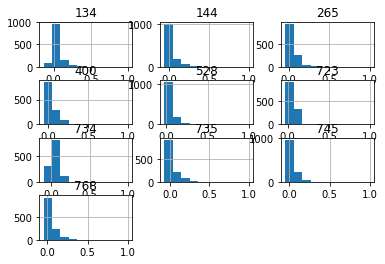

In [23]:
%matplotlib inline 
pd.DataFrame(sims).loc[:,df.index].hist()

In [24]:
raw_corpus[144]

'For acquisition of lands within the exterior boundaries of the Cache, Uinta, and Wasatch National Forests, Utah; the Toiyabe National Forest, Nevada; and the Angeles, San Bernardino, Sequoia, and Cleveland National Forests, California; and the Ozark-St. Francis and Ouachita National Forests, Arkansas; as authorized by law, $700,000, to be derived from forest receipts.'

In [34]:
corpus[271]

['authorize',
 'exist',
 'fund',
 'provide',
 'executive',
 'branch',
 'agency',
 'produce',
 'prepackage',
 'news',
 'story',
 'intend',
 'broadcast',
 'distribution',
 'united',
 'states',
 'story',
 'include',
 'clear',
 'notification',
 'text',
 'audio',
 'prepackage',
 'news',
 'story',
 'prepackage',
 'news',
 'story',
 'prepare',
 'fund',
 'executive',
 'branch',
 'agency']

In [39]:
dictionary.token2id['butterfly']

2136

In [41]:
for i, doc in enumerate(tokened_corpus):
    for entry in doc:
        if entry[0] == 2136:
            print(i)

234


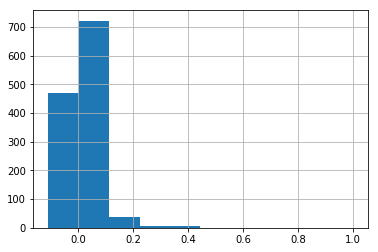

In [42]:
df.loc[:,234].hist()

In [61]:
# cluster with hdbscan
import hdbscan
hdb = hdbscan.HDBSCAN()
hdb.fit(lsi_array)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

In [62]:
hdb.labels_

array([ 1, -1,  1, ...,  1,  1,  1])

In [63]:
hdb.labels_.max()

2

In [64]:
outlier_docs = []

for index, label in enumerate(hdb.labels_):
    if label == -1:
        outlier_docs.append(index)

In [65]:
len(outlier_docs)

200